In [13]:
import random
import numpy as np
import math
import time

from numba import jit,prange

from helper_functions import *
from deletion_functions import *
from inference_metaheuristics import *
from trace_reconstruction_heuristics import *

from tqdm import tnrange, tqdm_notebook
import multiprocessing as mp
from itertools import repeat

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()
sns.set_style('whitegrid')

In [14]:
def one_iter(N,A,T_s,delta, method = None, method_params = None):
    
    X = randseq_uniform(N,A)
    Y_list = []
    
    hamming_error_rates = []
    
    for t in range(1,max(T_s)+1):
        Y_list.append(dc(X,delta))
        
        if t in T_s:
            if method == 'proj_grad_asc_traces':
                Xhat = proj_grad_asc_traces(method_params['P_init'],Y_list,lambda_grad,\
                                     lambda_forward,delta,step_size = 0.1,\
                                     tolerance = 1e-6,max_grad_steps = 100)
            elif method == 'symbolwise_map_seq':
                Xhat = symbolwise_map_seq(method_params['P_init'],Y_list,lambda_grad,delta)
                
            elif method == 'symbolwise_map_exact':
                Xhat = symbolwise_map_exact(method_params['P_init'],Y_list,delta)
            else:
                raise ValueError('Method not implemented')
            
            hamming_error_rates.append(hamming_error_rate(Xhat,X))
    
#     print(X,Xhat)
    return np.array(hamming_error_rates)

In [15]:
##### Warming up numba and the functions #####
import warnings
warnings.filterwarnings('ignore')

N = 10
A = 2
T_s = [1]
delta = 0.2

method = 'proj_grad_asc_traces'
method_params = {}
method_params['P_init'] = 1/A * np.ones((N,A))
one_iter(N,A,T_s,delta, method, method_params)

method = 'symbolwise_map_seq'
method_params = {}
method_params['P_init'] = 1/A * np.ones((N,A))
one_iter(N,A,T_s,delta, method, method_params)

method = 'symbolwise_map_exact'
method_params = {}
method_params['P_init'] = 1/A * np.ones((N,A))
one_iter(N,A,T_s,delta, method, method_params)

array([0.1])

In [41]:
N = 500
A = 2
T_s = [1]
delta = 0.2

method = 'symbolwise_map_seq'
method_params = {}
method_params['P_init'] = 1/A * np.ones((N,A))
one_iter(N,A,T_s,delta, method, method_params)

array([0.412])

In [16]:
def gen_error_rates(N,A,T_s,delta_vec, method = None, method_params = None, hyperiters = 100,process_per_hyperiter = 100):
    
    results = {}
    results['summary'] = ("Hamming error rates and likelihood gains for a blocklength of {}, "
    "an alphabet size {} using the method {}".format(N,A,method))
    
    results['delta_vec'] = delta_vec
    
    hamming_error_list = np.zeros((len(delta_vec),len(T_s)))
    #likelihood_gain_list = np.zeros((len(delta_vec),hyperiters*process_per_hyperiter))
    
    for idx, delta in enumerate(delta_vec):
#         print('Computing for delta = ',delta)
        time.sleep(0.4)
        pool = mp.Pool(mp.cpu_count())
        for it in tnrange(hyperiters):
            temp = pool.starmap(one_iter, zip(repeat(N),repeat(A),repeat(T_s),delta*np.ones(process_per_hyperiter),\
                                              repeat(method),repeat(method_params)))
            temp = np.array(temp)
            hamming_error_list[idx,:] += temp.sum(axis = 0)
            #likelihood_gain_list[idx,it*process_per_hyperiter:(it+1)*process_per_hyperiter] = temp[:,1]
        pool.close()
    
    hamming_error_list /= hyperiters * process_per_hyperiter
    results['hamming_error_list'] = hamming_error_list
#     results['likelihood_gain_list'] = likelihood_gain_list
    
    return results

In [17]:
import warnings
warnings.filterwarnings('ignore')

N = 40
A = 2
T_s = [1,2,3,4]
delta_vec = np.arange(0.1,0.6,0.1)

hyperiters = 40
process_per_hyperiter = 40

errors = {}

methods = ['proj_grad_asc_traces','symbolwise_map_seq','symbolwise_map_exact']

for method in methods:
    print('*'*50,'\n',method,'\n','*'*50)
    method_params = {}
    method_params['P_init'] = 1/A * np.ones((N,A))
    errors[method] = gen_error_rates(N,A,T_s,delta_vec, method, method_params,hyperiters,process_per_hyperiter)

************************************************** 
 proj_grad_asc_traces 
 **************************************************



************************************************** 
 symbolwise_map_seq 
 **************************************************



************************************************** 
 symbolwise_map_exact 
 **************************************************


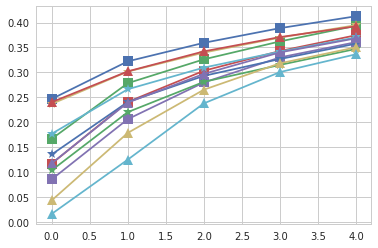

In [19]:
plt.plot(errors['proj_grad_asc_traces']['hamming_error_list'],marker = 's',markersize = 10)
plt.plot(errors['symbolwise_map_seq']['hamming_error_list'],marker = '*',markersize = 10)
plt.plot(errors['symbolwise_map_exact']['hamming_error_list'],marker = '^',markersize = 10)



In [20]:
errors

{'proj_grad_asc_traces': {'summary': 'Hamming error rates and likelihood gains for a blocklength of 40, an alphabet size 2 using the method proj_grad_asc_traces',
  'delta_vec': array([0.1, 0.2, 0.3, 0.4, 0.5]),
  'hamming_error_list': array([[0.24673438, 0.16671875, 0.11704688, 0.08548437],
         [0.32220313, 0.27842188, 0.24082813, 0.20623437],
         [0.359375  , 0.32621875, 0.30334375, 0.27989062],
         [0.38878125, 0.36217187, 0.3429375 , 0.33010938],
         [0.41265625, 0.39346875, 0.37460938, 0.36070312]])},
 'symbolwise_map_seq': {'summary': 'Hamming error rates and likelihood gains for a blocklength of 40, an alphabet size 2 using the method symbolwise_map_seq',
  'delta_vec': array([0.1, 0.2, 0.3, 0.4, 0.5]),
  'hamming_error_list': array([[0.23673437, 0.17690625, 0.13542187, 0.10365625],
         [0.30167187, 0.26623437, 0.24067187, 0.22042187],
         [0.33971875, 0.30967188, 0.29309375, 0.2810625 ],
         [0.36985937, 0.34178125, 0.3268125 , 0.31498437],
  

In [21]:
np.save('errors_BL40.npy',errors)

In [35]:
temp = np.load('errors_BL40.npy',allow_pickle = True).item()

In [36]:
temp

{'proj_grad_asc_traces': {'summary': 'Hamming error rates and likelihood gains for a blocklength of 40, an alphabet size 2 using the method proj_grad_asc_traces',
  'delta_vec': array([0.1, 0.2, 0.3, 0.4, 0.5]),
  'hamming_error_list': array([[0.24673438, 0.16671875, 0.11704688, 0.08548437],
         [0.32220313, 0.27842188, 0.24082813, 0.20623437],
         [0.359375  , 0.32621875, 0.30334375, 0.27989062],
         [0.38878125, 0.36217187, 0.3429375 , 0.33010938],
         [0.41265625, 0.39346875, 0.37460938, 0.36070312]])},
 'symbolwise_map_seq': {'summary': 'Hamming error rates and likelihood gains for a blocklength of 40, an alphabet size 2 using the method symbolwise_map_seq',
  'delta_vec': array([0.1, 0.2, 0.3, 0.4, 0.5]),
  'hamming_error_list': array([[0.23673437, 0.17690625, 0.13542187, 0.10365625],
         [0.30167187, 0.26623437, 0.24067187, 0.22042187],
         [0.33971875, 0.30967188, 0.29309375, 0.2810625 ],
         [0.36985937, 0.34178125, 0.3268125 , 0.31498437],
  